![NeighborNorm logo](../assets/logo.png)

# Experiment: Spatial Sticky Gene Corrections

Use this notebook to load an AnnData (`.h5ad`) file, run sticky-gene correction features, and inspect/plot outputs.


In [23]:
from __future__ import annotations

from pathlib import Path
import importlib
import sys

import numpy as np
import pandas as pd
import scanpy as sc

def find_repo_root(start: Path) -> Path:
    for candidate in (start, *start.parents):
        if (candidate / "spatial_sticky_gene_corrections.py").exists():
            return candidate
    raise FileNotFoundError("Could not find repo root from current working directory.")

REPO_ROOT = find_repo_root(Path.cwd().resolve())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import spatial_sticky_gene_corrections as ssgc
ssgc = importlib.reload(ssgc)

compute_spatial_sticky_gene_corrections = ssgc.compute_spatial_sticky_gene_corrections
plot_sticky_gene_views = ssgc.plot_sticky_gene_views
discover_spatially_sticky_genes = getattr(ssgc, "discover_spatially_sticky_genes", None)
if discover_spatially_sticky_genes is None:
    raise ImportError(
        "discover_spatially_sticky_genes not found in spatial_sticky_gene_corrections.py. "
        "Save/pull latest module and restart or re-run this cell."
    )

print(f"Repo root: {REPO_ROOT}")


Repo root: /Users/christoffer/work/karolinska/development/NeighborNorm


## Load AnnData

Set `DATA_PATH` to your `.h5ad` file path. Relative paths are resolved from repo root.\n

In [24]:
DATA_PATH = "/Volumes/processing2/BALO/baloMS_indep_clust_balo_MANA_SC.h5ad"  # change this
adata = sc.read_h5ad(DATA_PATH)
adata

/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 202751 × 5101
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'run', 'sample_id', 'n_genes_by_counts', 'n_counts', 'n_genes', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'gmm_mana_5', 'gmm_mana_8', 'gmm_mana_10', 'gmm_mana_12', 'gmm_mana_15', 'gmm_mana_20'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_mana_gauss_params', 'gmm_mana_10_colors', 'gmm_mana_15_colors', 'gmm_mana_5_colors', 'gmm_mana_8_colors', 'hvg', 'leiden_0.5', 'leiden_0.5_colors', 'leiden_1', 'leiden_1.5', 'leiden_1.5_colors', 'leiden_1_colors', 'leiden_2', 'leiden_2_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_

In [25]:
print(f"n_obs={adata.n_obs:,}, n_vars={adata.n_vars:,}")
print("obs columns:", list(adata.obs.columns)[:15])
print("obsm keys:", list(adata.obsm.keys()))

if "spatial" not in adata.obsm:
    raise KeyError("adata.obsm['spatial'] is required for this workflow.")

n_obs=202,751, n_vars=5,101
obs columns: ['x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'run', 'sample_id']
obsm keys: ['X_mana_gauss', 'X_pca', 'X_scVI', 'X_umap', 'spatial']


## Discover + Run Corrections
Use `sample_id` so spatial neighbors and correction are computed within each sample (no cross-sample mixing).


In [ ]:
ranking = discover_spatially_sticky_genes(
    adata,
    n_neighbors=15,
    key="spatial_neighbors",
    sample_key="sample_id",
    layer_counts="counts",
    min_samples_eligible_frac=1.0,
    score_weights={
        "neighbor_corr": 0.45,
        "moran_i": 0.45,
        "contrast_mad": 0.10,
        "detect_frac": 0.0,
    },
    top_k=20,
)

ranking.head(20)


[info] Created adata.layers['log1p_cpm'] from 'counts'.
[info] Built sample-wise neighbors for sample_id='S07-256': n_obs=109818, n_neighbors=15.
[info] Built sample-wise neighbors for sample_id='S13-019': n_obs=92933, n_neighbors=15.
[info] Built sample-aware spatial neighbors with key='spatial_neighbors', n_neighbors=15, sample_key='sample_id', n_samples=2.


In [5]:
sticky_genes = ["MBP", "GFAP"]  # seed genes; change as needed
discovered_genes = adata.uns.get("sticky_gene_ranking_top_genes", [])[:10]
sticky_genes_for_correction = list(dict.fromkeys(sticky_genes + discovered_genes))

adata = compute_spatial_sticky_gene_corrections(
    adata,
    sticky_genes=sticky_genes_for_correction,
    n_neighbors=15,
    key="spatial_neighbors",
    sample_key="sample_id",
    layer_counts="counts",
    do_field_residual=True,
)

print("Discovered sticky genes:", discovered_genes)
print("Using genes for correction:", sticky_genes_for_correction)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[info] Created adata.layers['log1p_cpm'] from 'counts'.


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[info] Built spatial neighbors with key='spatial_neighbors', n_neighbors=15.
[info] Regression covariates: intercept, log1p_total_counts, local_density
[info] Computed features for MBP: local_contrast, resid, field_resid.
[info] Computed features for GFAP: local_contrast, resid, field_resid.


In [12]:
ranking.loc["COL4A1", [
    "stickiness_score", "neighbor_corr", "moran_i",
    "detect_frac", "contrast_mad", "eligible"
]]

stickiness_score    0.522643
neighbor_corr       0.437421
moran_i             0.231419
detect_frac         0.118022
contrast_mad        0.116281
eligible                True
Name: COL4A1, dtype: object

In [11]:
new_cols = [
    c
    for c in adata.obs.columns
    if c.endswith("_local_contrast") or c.endswith("_resid") or c.endswith("_field_resid")
]
adata.obs[new_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
MBP_local_contrast,202751.0,1.546798e-03,1.755846,-6.216914,-0.896367,0.288217,1.184258,6.164262
MBP_resid,202751.0,-4.229275e-13,2.144892,-4.027733,-1.104663,0.642508,1.660695,5.020174
MBP_field_resid,202751.0,1.546798e-03,1.755846,-6.216914,-0.896367,0.288217,1.184258,6.164262
GFAP_local_contrast,202751.0,9.751591e-04,1.375402,-7.117459,-0.648244,0.000000,0.741002,7.455686
GFAP_resid,202751.0,-4.080886e-13,2.418830,-5.660038,-1.059043,0.830194,1.720214,5.290673
GFAP_field_resid,202751.0,9.751591e-04,1.375402,-7.117459,-0.648244,0.000000,0.741002,7.455686
COL4A1_local_contrast,202751.0,-1.921453e-03,1.083445,-4.509436,-0.365692,-0.074360,0.000000,6.884087
COL4A1_resid,202751.0,1.225790e-13,1.185668,-1.128587,-0.529595,-0.364022,-0.211132,6.734610
COL4A1_field_resid,202751.0,-1.921453e-03,1.083445,-4.509436,-0.365692,-0.074360,0.000000,6.884087
NR4A1_local_contrast,202751.0,-2.048820e-03,1.195322,-4.882150,-0.453853,-0.154128,0.000000,6.429988


/Users/christoffer/work/karolinska/development/NeighborNorm/spatial_sticky_gene_corrections.py:280: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata, color=cols, spot_size=spot_size, cmap=cmap)


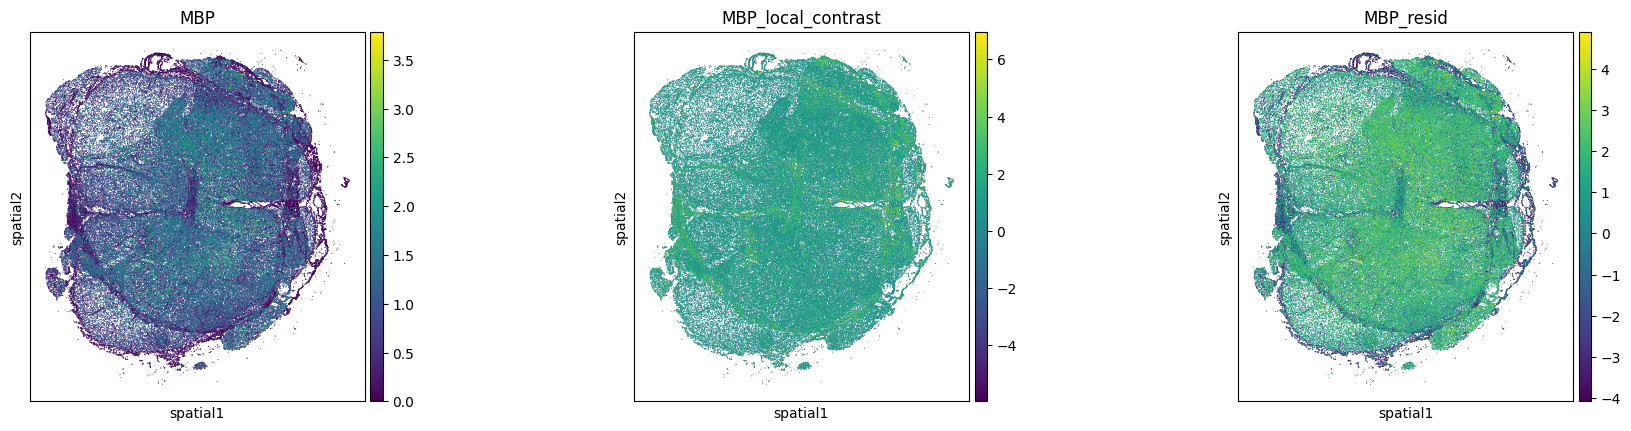

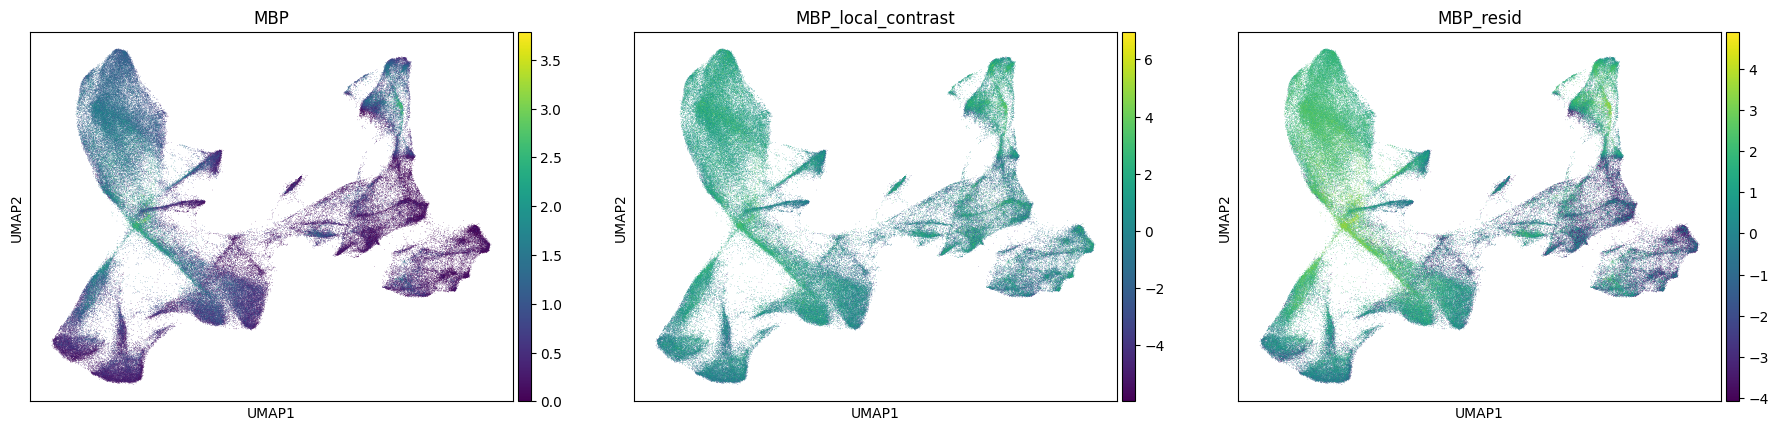

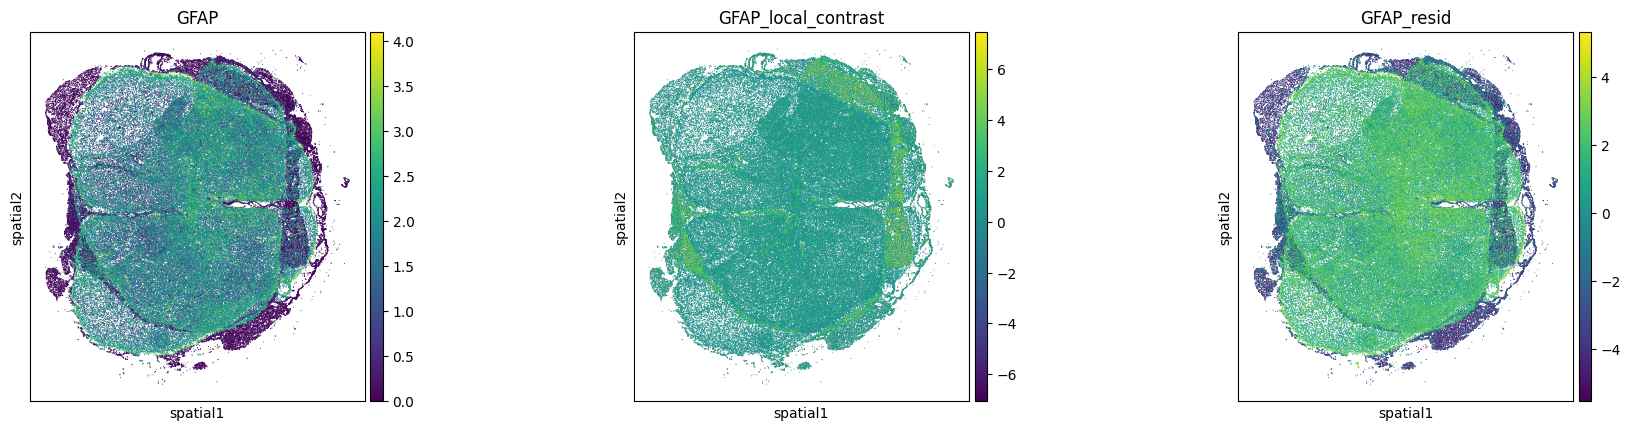

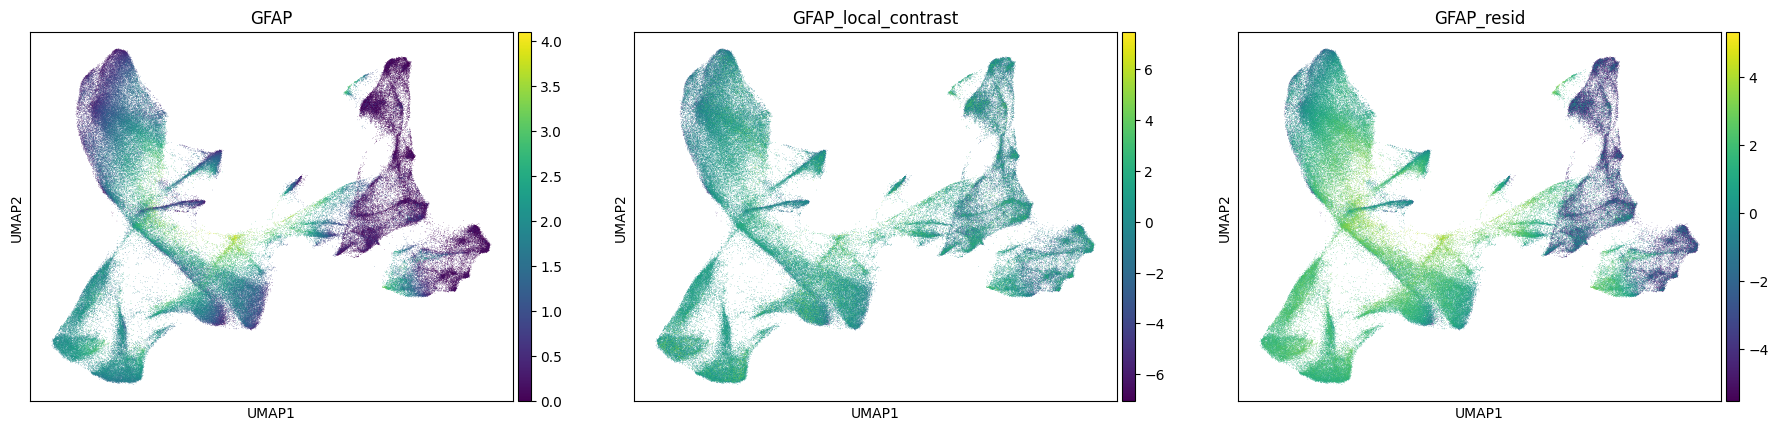

In [7]:
plot_sticky_gene_views(
    adata,
    genes=sticky_genes_for_correction[:8],
    spot_size=30.0,
    cmap="viridis",
    sample_key="sample_id",
    tile_samples=True,
)


## Cell-Type-Adjusted Stickiness (Recommended)
This section removes cell-type + library-size effects before spatial stickiness scoring, then computes a conditional permutation null.


In [26]:
import celltype_adjusted_stickiness as ctas
ctas = importlib.reload(ctas)

stickiness = ctas.stickiness
stickiness_diagnostics = ctas.stickiness_diagnostics


In [28]:
adata

AnnData object with n_obs × n_vars = 202751 × 5101
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'run', 'sample_id', 'n_genes_by_counts', 'n_counts', 'n_genes', 'leiden_0.5', 'leiden_1', 'leiden_1.5', 'leiden_2', 'gmm_mana_5', 'gmm_mana_8', 'gmm_mana_10', 'gmm_mana_12', 'gmm_mana_15', 'gmm_mana_20'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'X_mana_gauss_params', 'gmm_mana_10_colors', 'gmm_mana_15_colors', 'gmm_mana_5_colors', 'gmm_mana_8_colors', 'hvg', 'leiden_0.5', 'leiden_0.5_colors', 'leiden_1', 'leiden_1.5', 'leiden_1.5_colors', 'leiden_1_colors', 'leiden_2', 'leiden_2_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_

In [ ]:
CTAS_CONN_KEY = (
    "spatial_neighbors_connectivities"
    if "spatial_neighbors_connectivities" in adata.obsp
    else "connectivities"
)
CTAS_CELL_TYPE_KEY = "cell_type" if "cell_type" in adata.obs else "leiden_2"

ctas_df = stickiness(
    adata,
    layer="counts" if "counts" in adata.layers else None,
    cell_type_key=CTAS_CELL_TYPE_KEY,
    total_counts_key="total_counts",
    connectivities_key=CTAS_CONN_KEY,
    key_added="stickiness",
    n_perm=200,
    random_state=0,
    compute_within_cell_type=True,
    min_cells_per_type=30,
    store_residuals=False,
    copy=False,
)

ctas_df.sort_values("z", ascending=False).head(30)


In [ ]:
marker_genes = ["COL4A1", "MBP", "GFAP"]
diag = stickiness_diagnostics(ctas_df, marker_genes=marker_genes)

print(
    "Spearman corr(detection_rate, naive stickiness):",
    diag["corr_detection_naive_spearman"],
)
print(
    "Spearman corr(detection_rate, residual stickiness):",
    diag["corr_detection_resid_spearman"],
)

diag["marker_rank_shift"]


## Optional: Save Result

In [ ]:
OUT_PATH = REPO_ROOT / "data" / "your_data.sticky_corrected.h5ad"
# adata.write_h5ad(OUT_PATH)
# print(f"Saved: {OUT_PATH}")